In [1]:
import numpy as np
from UAV import *
import random
from sklearn.manifold import MDS
import matplotlib.pyplot as plt           # for plotting

### Definition of the Distance Matrix

In [2]:
n_robots = 3#int(input("number of robots: "))
platoon = []

c_set = ['black'] + ['green' for i in range(1,n_robots)]

# initialization of n robots
for i in range(n_robots):
    if i==0:
        i_robot = Robot("op_" + str(i),0,0,0)
    else:
        i_robot = Robot("op_" + str(i),random.uniform(0, 10.0),random.uniform(0, 10.0),0)
    platoon.append(i_robot)

coordinates = [[],[],[]]

for rob in platoon:
    coordinates = np.append(coordinates,rob.get_coords(),axis=1)

S = coordinates[0:2,:]

DM  = d_matrix(platoon)
DM2 = d_matrix2(platoon)
print(DM)
print(DM2)

[[ 0.         10.06620365  7.94651441]
 [10.06620365  0.          5.80417069]
 [ 7.94651441  5.80417069  0.        ]]
[[  0.         101.32845601  63.14709123]
 [101.32845601   0.          33.68839735]
 [ 63.14709123  33.68839735   0.        ]]


### Identity matrix

In [3]:
I   = np.eye(n_robots)
print(I)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


### Definition of the e vector and the H matrix

In [4]:
e   = np.array([[1] for i in range(n_robots)])

H = I - (e*e.T)/n_robots
print(H)

[[ 0.66666667 -0.33333333 -0.33333333]
 [-0.33333333  0.66666667 -0.33333333]
 [-0.33333333 -0.33333333  0.66666667]]


### Eigendecomposition of the matrix -1/2HDH

In [5]:
print(-1/2*H*DM*H,'\n')

#Eigenvalues ev, eigenvectors EV
ev,EV = np.linalg.eig(-1/2*H*DM*H)

#Lambda is the diagonal matrix whose elements are the eigenvalues
LAMBDA = np.eye(n_robots)*ev

#U is the matrix whose columns are the eigenvectors
U      = np.transpose(EV)
print(LAMBDA,'\n\n',U)

#Sstar  = np.sqrt(LAMBDA).transpose(U)
#print(Sstar)

[[-0.         -0.55923354 -0.44147302]
 [-0.55923354 -0.         -0.32245393]
 [-0.44147302 -0.32245393 -0.        ]] 

[[-0.88919962  0.          0.        ]
 [-0.          0.58101881  0.        ]
 [-0.          0.          0.3081808 ]] 

 [[-0.62456312 -0.5817482  -0.52104696]
 [-0.76313071  0.59641001  0.24885058]
 [-0.16598925 -0.55304984  0.81644562]]


### Scikit learn MDS approach

In [6]:
n_components = 2                                   # p, reduced dimensionality space
embedding = MDS(n_components=2,
                n_init = 50,
                max_iter = 10000,
                eps=1e-5,
                dissimilarity='precomputed') # instantiate and set the hyperparameter
                
Sstar = embedding.fit_transform(DM).T
Sstar2= embedding.fit_transform(DM2).T

print(Sstar)
print(S)

[[-2.02201135 -1.10642662  3.12843797]
 [-5.35839957  4.66491665  0.69348292]]
[[0.         9.94784399 5.72022071]
 [0.         1.53910882 5.51599187]]


#### Plot

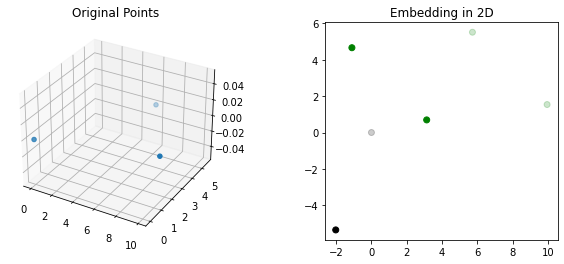

In [7]:
fig = plt.figure(2, (10,4))
ax = fig.add_subplot(121, projection='3d')
ax.scatter3D(coordinates[0,:], coordinates[1,:], coordinates[2,:])
plt.title('Original Points')

ax = fig.add_subplot(122)
plt.scatter(Sstar[0,:], Sstar[1,:], color=c_set, alpha=1.0)
plt.scatter(S    [0,:], S    [1,:], color=c_set, alpha=0.2)
plt.title('Embedding in 2D')
fig.subplots_adjust(wspace=.4, hspace=0.5)
plt.show()

### Introduction of the controlled displacement

In [8]:
deltaX = deltaY = 0.1

deltaSprime = np.array([[0 for i in range(n_robots)] for j in range(2)],dtype=float)
deltaSprime[:,0] = [deltaX,deltaY]
print(deltaSprime)

[[0.1 0.  0. ]
 [0.1 0.  0. ]]


In [9]:
Sprime = S + deltaSprime
print(Sprime)

[[0.1        9.94784399 5.72022071]
 [0.1        1.53910882 5.51599187]]


### Phi prime definition

In [10]:
Phiprime = np.array([np.diag(Sprime.T@Sprime)]).T
print(Phiprime)

DMprime = Phiprime@e.T - 2*Sprime.T@Sprime + e@Phiprime.T

[[2.00000000e-02]
 [1.01328456e+02]
 [6.31470912e+01]]


Let's have a look at the distance matrices. They are pretty similar, since the displacement is very small. GOOD

In [11]:
print(DMprime)
print(DM2)

[[ 0.         99.05106545 60.91984872]
 [99.05106545  0.         33.68839735]
 [60.91984872 33.68839735  0.        ]]
[[  0.         101.32845601  63.14709123]
 [101.32845601   0.          33.68839735]
 [ 63.14709123  33.68839735   0.        ]]


DMprime breakdown analysis (as on the paper)

In [12]:
piece1 = DM2 - DMprime
print(piece1)

[[0.00000000e+00 2.27739056e+00 2.22724252e+00]
 [2.27739056e+00 0.00000000e+00 0.00000000e+00]
 [2.22724252e+00 7.10542736e-15 0.00000000e+00]]


In [13]:
piece2 = np.zeros((n_robots,n_robots))
piece2[1:,0] = (deltaX**2 + deltaY**2)*np.ones(n_robots-1)
piece2[0,1:] = (deltaX**2 + deltaY**2)*np.ones(n_robots-1)
print(piece2)

[[0.   0.02 0.02]
 [0.02 0.   0.  ]
 [0.02 0.   0.  ]]


In [14]:
piece3 = -2*((S.T@deltaSprime).T + S.T@deltaSprime)
print(piece3)

[[-0.         -2.29739056 -2.24724252]
 [-2.29739056 -0.         -0.        ]
 [-2.24724252 -0.         -0.        ]]


In [15]:
#FINAL RESULT [SHOULD BE VERY CLOSED TO ZERO --> GOOD]
print(piece1+piece2+piece3)

[[ 0.00000000e+00 -2.22044605e-15  6.66133815e-15]
 [-2.22044605e-15  0.00000000e+00  0.00000000e+00]
 [ 6.66133815e-15  7.10542736e-15  0.00000000e+00]]


In [16]:
a2 = DM2[0,1] - DMprime[0,1] + deltaX**2 + deltaY**2
b2 = -2*(Sstar[0,1]*deltaX + Sstar[1,1]*deltaY)    
c2 =  2*(Sstar[0,1]*deltaY - Sstar[1,1]*deltaX)    

a3 = DM2[0,2] - DMprime[0,2] + deltaX**2 + deltaY**2
b3 = -2*(Sstar[0,2]*deltaX + Sstar[1,2]*deltaY)     
c3 =  2*(Sstar[0,2]*deltaY - Sstar[1,2]*deltaX)    

sinTheta = (a3*b2-a2*b3)/(b3*c2-b2*c3)
cosTheta = (a2*c3-a3*c2)/(b3*c2-b2*c3)
print(sinTheta,cosTheta)
theta = np.arctan2(sinTheta,cosTheta)
print('Theta: %f' % (theta))

mod = np.sqrt(sinTheta**2+cosTheta**2)
sinTheta /= mod
cosTheta /= mod

theta = np.arctan2(sinTheta,cosTheta)

print('Theta: %f' % (theta))
print(sinTheta**2+cosTheta**2)


0.12753811091494618 3.02119339686861
Theta: 0.042189
Theta: 0.042189
0.9999999999999999


In [17]:
#rotMatrix = np.array([[cosTheta,sinTheta],[-sinTheta,cosTheta]])
print(rotateMatrix(theta))

[[ 0.99911016  0.04217692]
 [-0.04217692  0.99911016]]


In [18]:
#Flip matrix
F = np.array([[-1,0],[0,1]])
print(F)

[[-1  0]
 [ 0  1]]


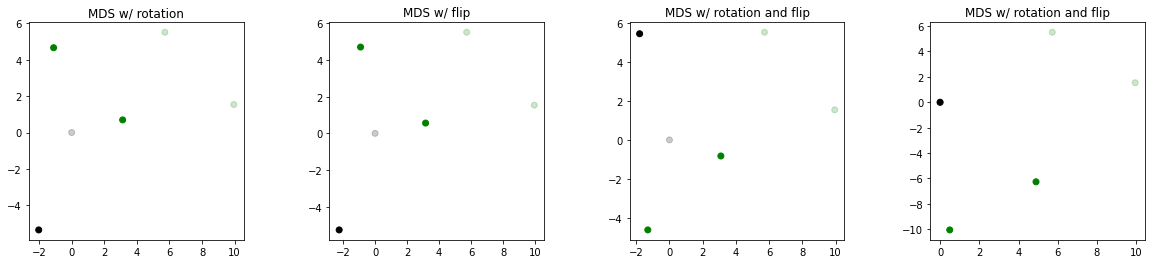

[[-2.24621285 -0.90869027  3.15490312]
 [-5.26834923  4.70743128  0.56091796]]
[[0.         9.94784399 5.72022071]
 [0.         1.53910882 5.51599187]]


In [19]:
S2 = rotateMatrix(theta)@Sstar
S3 = rotateMatrix(np.pi)@rotateMatrix(theta)@F@Sstar

fig = plt.figure(3, (20,4))
ax = fig.add_subplot(141)
plt.scatter(Sstar[0,:], Sstar[1,:], color=c_set, alpha=1.0)
plt.scatter(S    [0,:], S    [1,:], color=c_set, alpha=0.2)
plt.title('MDS w/ rotation')
fig.subplots_adjust(wspace=.4, hspace=0.5)

ax = fig.add_subplot(142)
plt.scatter(S2[0,:], S2[1,:], color=c_set, alpha=1.0)
plt.scatter(S [0,:], S [1,:], color=c_set, alpha=0.2)
plt.title('MDS w/ flip')
fig.subplots_adjust(wspace=.4, hspace=0.5)

ax = fig.add_subplot(143)
plt.scatter(S3[0,:], S3[1,:], color=c_set, alpha=1.0)
plt.scatter(S [0,:], S [1,:], color=c_set, alpha=0.2)
plt.title('MDS w/ rotation and flip')
fig.subplots_adjust(wspace=.4, hspace=0.5)

ax = fig.add_subplot(144)
plt.scatter(S3[0,:]-[S3[0,0] for _ in range(n_robots)], S3[1,:]-[S3[1,0] for _ in range(n_robots)], color=c_set, alpha=1.0)
plt.scatter(S [0,:], S [1,:], color=c_set, alpha=0.2)
plt.title('MDS w/ rotation and flip')
fig.subplots_adjust(wspace=.4, hspace=0.5)
plt.show()

print(S2)
print(S)

### Flip and Rotation: Simultaneously

In [20]:
a2 = DM2[0,1] - DMprime[0,1] + deltaX**2 + deltaY**2
b2 = -2*(Sstar[0,1]*deltaX + Sstar[1,1]*deltaY)    
c2 =  2*(Sstar[0,1]*deltaY - Sstar[1,1]*deltaX)    

a3 = DM2[0,2] - DMprime[0,2] + deltaX**2 + deltaY**2
b3 = -2*(Sstar[0,2]*deltaX + Sstar[1,2]*deltaY)     
c3 =  2*(Sstar[0,2]*deltaY - Sstar[1,2]*deltaX)  

Coincise form, as seen on eqs (27) and (28) in the paper

In [23]:
theta11 = theta1i(Sstar,S,1)
THETA1  = THETAi(S,[deltaX,deltaY],1)
theta12 = theta2i(theta11,THETA1)

theta21 = theta1i(Sstar,S,2)
THETA2  = THETAi(S,[deltaX,deltaY],2)
theta22 = theta2i(theta11,THETA2)

1.6501727963895356 -0.5490809339259193


If theta11 != theta21, there exists flip

In [30]:
print(theta11,theta21)
print(theta12,theta22)

1.6501727963895356 -0.5490809339259193
0.3863779444155029 1.613824898458533
